In [1]:
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
from pmdarima import auto_arima

In [6]:
PATH_ONE = '../Data/DailyTotalFemaleBirths.csv'
df1 = pd.read_csv(PATH_ONE, index_col='Date', parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]

In [7]:
PATH_TWO = '../Data/TradeInventories.csv'
df2 = pd.read_csv(PATH_TWO, index_col='Date', parse_dates=True)
df2.index.freq = "MS"

# ARMA

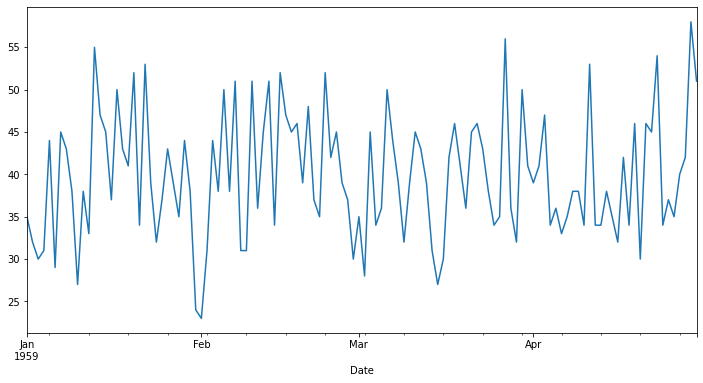

In [8]:
df1['Births'].plot(figsize=(12,6))

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [11]:
train = df1.iloc[:90]
test = df1.iloc[90:]

In [12]:
model = ARMA(train['Births'], order=(2,2))

In [13]:
results = model.fit()

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Sat, 13 Jun 2020   AIC                            627.809
Time:                        23:13:56   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.500      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.800      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.556      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7434           +0.0000j            1.7434            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

In [15]:
start = len(train)
end = len(train) + len(test) - 1

In [16]:
predictions = results.predict(start, end).rename('ARMA (2,2) Predictions')

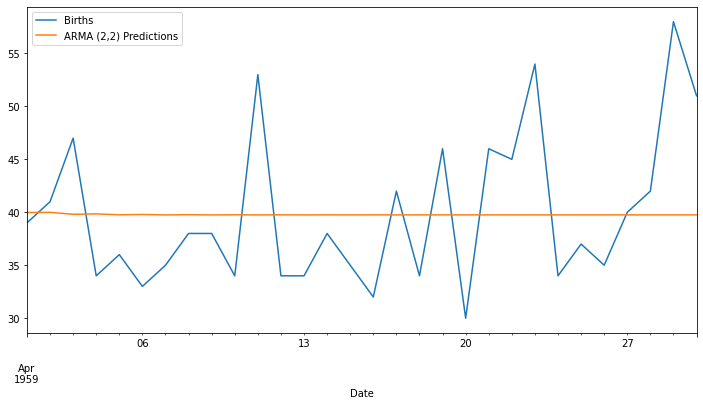

In [17]:
test['Births'].plot(figsize=(12, 6), legend=True)
predictions.plot(legend=True)

In [18]:
test.mean()

Births    39.833333
dtype: float64

In [19]:
predictions.mean()

39.77743071432967

# ARIMA

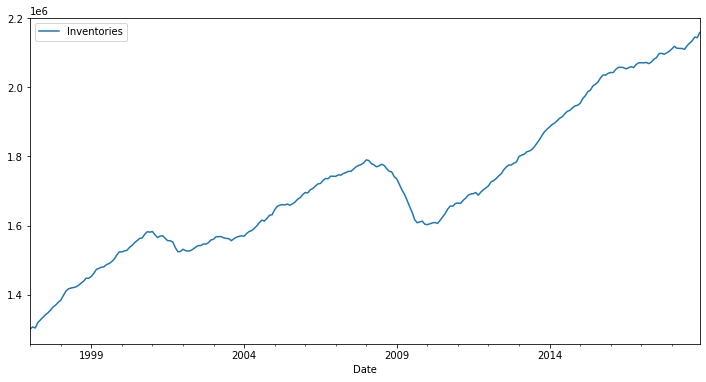

In [20]:
df2.plot(figsize=(12,6))

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
result = seasonal_decompose(df2['Inventories'], model='add')

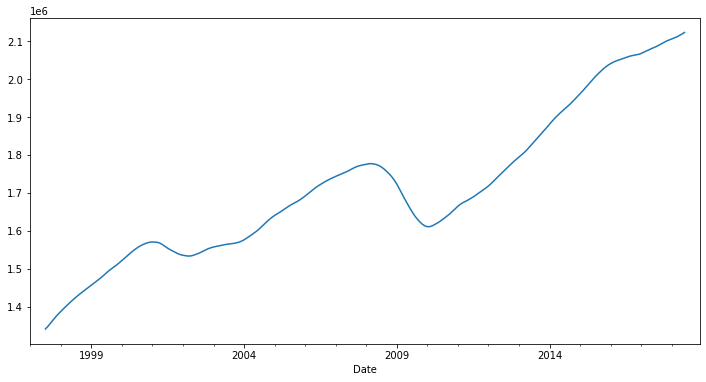

In [23]:
result.trend.plot(figsize=(12,6))

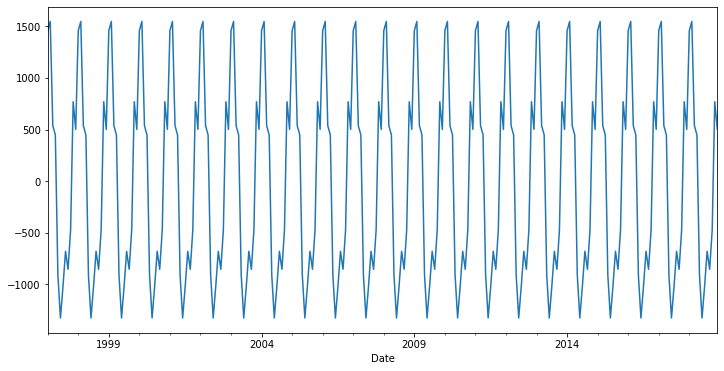

In [24]:
result.seasonal.plot(figsize=(12,6))

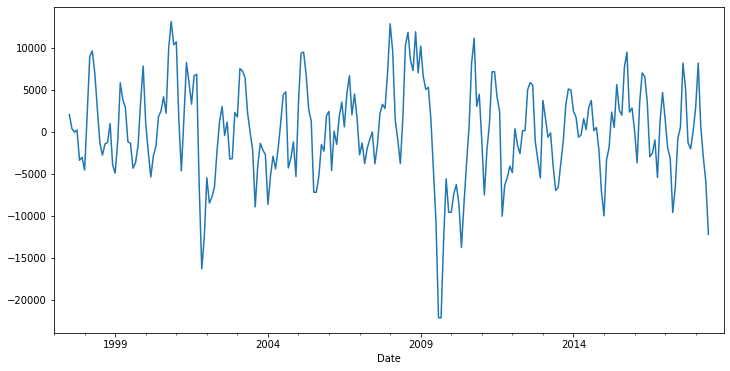

In [25]:
result.resid.plot(figsize=(12,6))

In [26]:
# ASSUMPTION: Seasonality is not present 
## NOTE: Seasonality is present in this case

auto_arima(df2['Inventories'], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.259
Date:                Sat, 13 Jun 2020   AIC                           5228.505
Time:                        23:13:58   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3463.1883   1313.147      2.637      0.008     889.468    6036.909
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1066           +0.0000j            1.1066            0.0000
MA.1            1.7447           +0.0000j            1.7447            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
from statsmodels.tsa.statespace.tools import diff

In [28]:
# d-value (I)

df2['Diff_1'] = diff(df2['Inventories'], k_diff=1)

In [29]:
adf_test(df2['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


From the <a href='https://people.duke.edu/~rnau/411arim3.htm'>Duke University Statistical Forecasting site</a>:
> If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms.

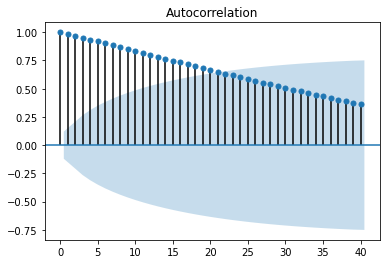

In [30]:
plot_acf(df2['Inventories'], lags=40);

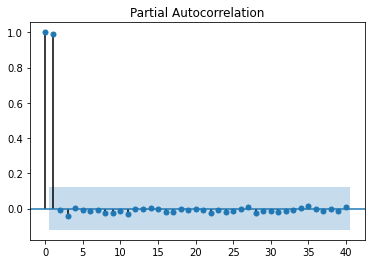

In [31]:
plot_pacf(df2['Inventories'], lags=40);

In [32]:
# AR = 1
# I = 1
# MA = 0 or 1

In [33]:
stepwise_fit = auto_arima(df2['Inventories'], 
                          start_p=0, start_q=0,
                          max_p=2, max_q=2,
                          seasonal=False,
                          trace=True)

Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.065 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.842, Fit time=0.075 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.527, BIC=5247.388, Fit time=0.288 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.093 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.325, BIC=5247.186, Fit time=0.070 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.686 seconds


In [34]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.259
Date:                Sat, 13 Jun 2020   AIC                           5228.505
Time:                        23:13:59   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3463.1883   1313.147      2.637      0.008     889.468    6036.909
ar.L1.D.y      0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1066           +0.0000j            1.1066            0.0000
MA.1            1.7447           +0.0000j            1.7447            0.0000
-----------------------------------------------------------------------------
"""

In [35]:
train = df2.iloc[:252]
test = df2.iloc[252:]

In [36]:
model = ARIMA(train['Inventories'], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Sat, 13 Jun 2020   AIC                           4980.790
Time:                        23:13:59   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.6171   1344.919      2.378      0.017     561.625    5833.610
ar.L1.D.Inventories     0.9026      0.039     23.013      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.049      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

In [37]:
start = len(train)
end = len(train) + len(test) - 1

In [38]:
# linear - differenced data
# levels - real data

predictions = results.predict(start=start, end=end, typ='levels').rename('ARIMA(1,1,1) Predictions')

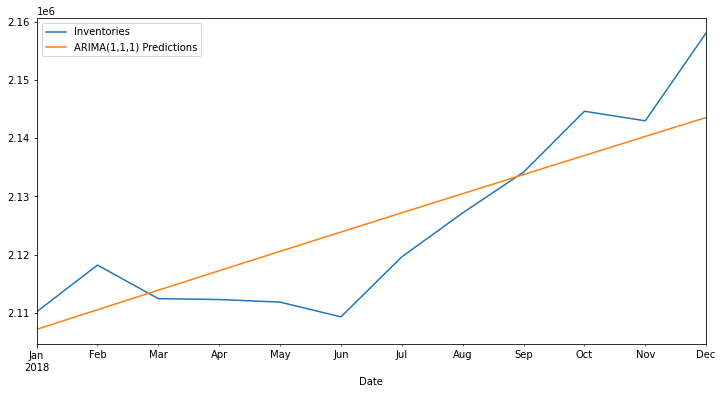

In [39]:
test['Inventories'].plot(figsize=(12,6), legend=True)
predictions.plot(legend=True)

In [40]:
from statsmodels.tools.eval_measures import rmse

In [41]:
error = rmse(test['Inventories'], predictions)

In [42]:
error

7789.561238050531

In [43]:
test['Inventories'].mean()

2125075.6666666665

In [44]:
predictions.mean()

2125465.342826205

In [45]:
# FORECAST

model = ARIMA(df2['Inventories'], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.259
Date:                Sat, 13 Jun 2020   AIC                           5228.505
Time:                        23:14:00   BIC                           5242.794
Sample:                    02-01-1997   HQIC                          5234.247
                         - 12-01-2018                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3463.1883   1313.147      2.637      0.008     889.468    6036.909
ar.L1.D.Inventories     0.9037      0.039     23.414      0.000       0.828       0.979
ma.L1.D.Inventories    -0.5732      0.076     -7.545      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1066           +0.0000j            1.1066            0.0000
MA.1            1.7447           +0.0000j            1.7447            0.0000
-----------------------------------------------------------------------------
"""

In [46]:
forecast = results.predict(start=len(df2), end=len(df2)+11, typ='levels').rename('ARIMA (1,1,1) Forecast')

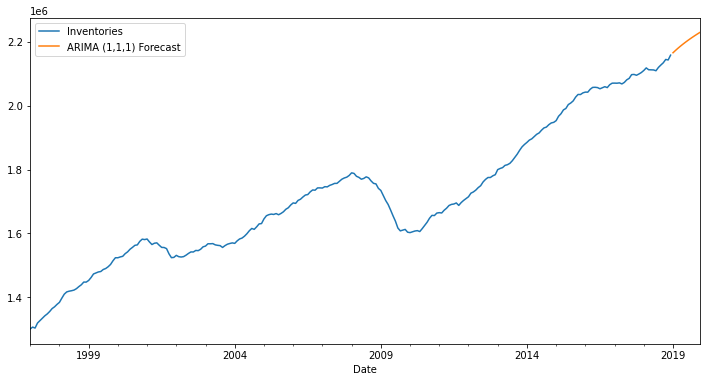

In [47]:
df2['Inventories'].plot(figsize=(12,6), legend=True)
forecast.plot(legend=True)